## Build test data

We'll use a star with a clear sinusoidal signal and multiple sectors for complete coverage on the different data types for targets that require TPF content.

We'll also generate a clear and a failure mode synthetic light curve for testing the detection methods.

We'll choose a single-sector star for download testing.

In [1]:
from fleck import generate_spots, Star
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
np.random.seed(802)
N = 2
spot_contrast = np.random.uniform(0.5, 1., size=N)
rotation_period = np.random.uniform(1.5, 27., size=N)/5
u_ld = [0.5, 0.2]

spot_radius = np.random.uniform(0.05, 0.15, size=N)
min_latitude = np.random.uniform(30, 60, size=N)
max_latitude = np.random.uniform(61, 85, size=N)

t = np.arange(0, 27., 0.02)
yerr = 1e-6*np.array([800, 100])

n_phases = len(t)
n_inclinations = 1
n_spots = np.random.uniform(10, 30, size=N).astype(int)

In [3]:
np.random.seed(802)

sim = np.zeros((N, len(t)))
obs = np.zeros((N, len(t)))

for idx in range(N):
    lons, lats, radii, inc_stellar = generate_spots(min_latitude[idx], max_latitude[idx],
                                                   spot_radius[idx], n_spots[idx],
                                                   n_inclinations=n_inclinations)
    star = Star(spot_contrast = spot_contrast[idx], n_phases=n_phases, 
                u_ld = u_ld, rotation_period = rotation_period[idx])
    lc = star.light_curve(lons, lats, radii, inc_stellar, times=t)
    
    lc -= np.mean(lc)
    lc += 1.
    
    sim[idx, :] = lc.flatten()
    obs[idx, :] = lc.flatten() + yerr[idx] * np.random.randn(len(t))


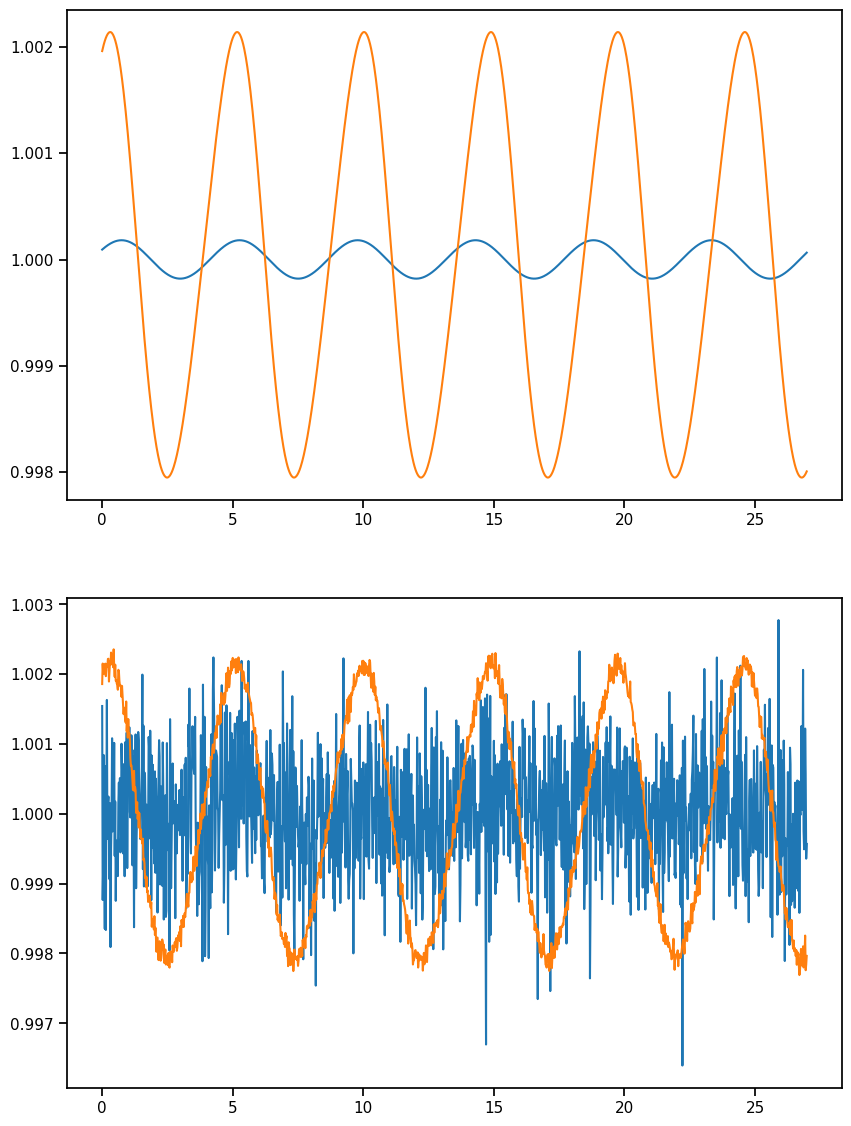

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
ax[0].plot(t, sim.T)
ax[1].plot(t, obs.T)
plt.show()

In [5]:
rotation_period

array([4.51813363, 4.86059959])

In [6]:
types = ['failure', 'pass']

for i in range(N):
    fname = f'tests/data/synthetic_{rotation_period[i]:.2f}_{types[i]}.txt'
    np.savetxt(fname, obs[i])

## Now let's check a simple double sector case for eleanor to test on

In [7]:
gaiaid = 4984094970441940864
ra = 20.457083
dec = -42.022861

In [8]:
from michael import janet

2022-10-17 16:58:50.663090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
j = janet(gaiaid, ra, dec, output_path = 'tests/data')

In [10]:
# j.run()

In [11]:
j.prepare_data()

Already have data downloaded for Gaia ID 4984094970441940864.


In [12]:
j.data.build_unpopular_lc()

Removing 49 bad data points (out of 1245) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 211 bad data points (out of 1288) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 63 bad data points (out of 3635) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 187 bad data points (out of 3783) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median


In [13]:
list(j.void)

['datum_2',
 'clc_2',
 'rawlc_2',
 'pcalc_2',
 'cornlc_2',
 'datum_3',
 'clc_3',
 'rawlc_3',
 'pcalc_3',
 'cornlc_3',
 'datum_29',
 'clc_29',
 'rawlc_29',
 'pcalc_29',
 'cornlc_29',
 'datum_30',
 'clc_30',
 'rawlc_30',
 'pcalc_30',
 'cornlc_30',
 'clc_2-3',
 'clc_29-30',
 'rawlc_2-3',
 'rawlc_29-30',
 'pcalc_2-3',
 'pcalc_29-30',
 'cornlc_2-3',
 'cornlc_29-30',
 'cpmlc_2',
 'cpm_2',
 'cpmlc_3',
 'cpm_3',
 'cpmlc_29',
 'cpm_29',
 'cpmlc_30',
 'cpm_30',
 'cpmlc_2-3',
 'cpmlc_29-30']

In [14]:
j.sectorlist

array([ 2,  3, 29, 30])

In [15]:
import glob
import lightkurve as lk
import tess_cpm
from astropy.coordinates import SkyCoord
import astropy.units as u
rastr = str(j.ra)
step = len(rastr.split('.')[0])
decstr = str(j.dec)
step = len(decstr.split('.')[0])
sfiles = np.sort(glob.glob(f'/Users/oliver hall/.eleanor/tesscut/*{rastr[:(6+step)]}*{decstr[:(6+step)]}*'))
coords = SkyCoord(ra = j.ra, dec = j.dec, unit = (u.deg, u.deg))

# Set up a standard aperture based on the `eleanor` aperture for a 50x50
# postcard.
for sfile, s in zip(sfiles, j.sectorlist):
    cpm = tess_cpm.Source(sfile, remove_bad=True)
    aperture = j.void[f'datum_{s}'].aperture
    rowlims = 20 + np.array([np.where(aperture)[0].min(), np.where(aperture)[0].max()])
    collims = 20 + np.array([np.where(aperture)[1].min(), np.where(aperture)[1].max()])
    cpm.set_aperture(rowlims = rowlims, collims = collims)

    # We use 200 predictors for a stamp of this size. This is a rough
    # guesstimate from trial-and-error, but seems to work well.
    cpm.add_cpm_model(exclusion_size=6, n=200,
        predictor_method = "similar_brightness")
    cpm.set_regs([0.1])
    cpm.holdout_fit_predict(k=100, verbose=False)

    # Save corrected flux as a lightcurve object for this sector
    flux = cpm.get_aperture_lc(data_type="cpm_subtracted_flux",
                                weighting='median')
    self.j.void[f'cpmlc_{s}'] = lk.LightCurve(time = cpm.time, flux = flux) + 1.
    self.j.void[f'cpm_{s}'] = cpm

Removing 49 bad data points (out of 1245) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median


NameError: name 'self' is not defined

In [16]:
import sys
import pytest
import os
import shutil

sys.path.append('../')

import numpy as np
from numpy.testing import assert_almost_equal, assert_array_equal
from michael import janet
from michael.data import data_class
import astropy.units as u
import glob
import lightkurve
# Using a known rotator from the Gaia catalogue
gaiaid = 4984094970441940864
ra = 20.457083
dec = -42.022861

j = janet(gaiaid, ra, dec, output_path = 'tests/data')
data = data_class(j)
data.check_eleanor_setup()

# Assert tess-sip generates lightkurve LightCurve object
data.build_tess_sip_lc()
for s in list(j.sectors):
    assert f'r_{s}' in list(j.void)
    assert f'rlc_{s}' in list(j.void)
    assert type(j.void[f'rlc_{s}']) == lightkurve.lightcurve

Already have data downloaded for Gaia ID 4984094970441940864.


/Users/Anaconda/anaconda3/envs/michael/lib/python3.10/site-packages/tess_sip/tess_sip.py:315: RuntimeWarning: divide by zero encountered in divide
  sigma_f_inv = sparse.csr_matrix(1 / lc.flux_err.value[:, None] ** 2)
Running pixels in aperture: 100%|████████████| 300/300 [00:01<00:00, 223.77it/s]
/Users/Anaconda/anaconda3/envs/michael/lib/python3.10/site-packages/tess_sip/tess_sip.py:315: RuntimeWarning: divide by zero encountered in divide
  sigma_f_inv = sparse.csr_matrix(1 / lc.flux_err.value[:, None] ** 2)
Running pixels in aperture: 100%|████████████| 300/300 [00:01<00:00, 181.90it/s]


AssertionError: 

In [19]:
type(j.void[f'rlc_{s}'])

lightkurve.lightcurve.TessLightCurve

In [21]:
assert type(j.void[f'rlc_{s}']) == lightkurve.lightcurve.TessLightCurve

In [24]:
data.check_eleanor_setup()

Already have data downloaded for Gaia ID 4984094970441940864.


In [28]:
data.build_eleanor_lc()

In [29]:
list(j.void)

['r_2-3',
 'rlc_2-3',
 'r_29-30',
 'rlc_29-30',
 'datum_2',
 'clc_2',
 'rawlc_2',
 'pcalc_2',
 'cornlc_2',
 'datum_3',
 'clc_3',
 'rawlc_3',
 'pcalc_3',
 'cornlc_3',
 'datum_29',
 'clc_29',
 'rawlc_29',
 'pcalc_29',
 'cornlc_29',
 'datum_30',
 'clc_30',
 'rawlc_30',
 'pcalc_30',
 'cornlc_30',
 'clc_2-3',
 'clc_29-30',
 'rawlc_2-3',
 'rawlc_29-30',
 'pcalc_2-3',
 'pcalc_29-30',
 'cornlc_2-3',
 'cornlc_29-30']

In [31]:
data.build_unpopular_lc()

Removing 49 bad data points (out of 1245) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 211 bad data points (out of 1288) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 63 bad data points (out of 3635) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 187 bad data points (out of 3783) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median


In [32]:
list(j.void)

['r_2-3',
 'rlc_2-3',
 'r_29-30',
 'rlc_29-30',
 'datum_2',
 'clc_2',
 'rawlc_2',
 'pcalc_2',
 'cornlc_2',
 'datum_3',
 'clc_3',
 'rawlc_3',
 'pcalc_3',
 'cornlc_3',
 'datum_29',
 'clc_29',
 'rawlc_29',
 'pcalc_29',
 'cornlc_29',
 'datum_30',
 'clc_30',
 'rawlc_30',
 'pcalc_30',
 'cornlc_30',
 'clc_2-3',
 'clc_29-30',
 'rawlc_2-3',
 'rawlc_29-30',
 'pcalc_2-3',
 'pcalc_29-30',
 'cornlc_2-3',
 'cornlc_29-30',
 'cpmlc_2',
 'cpm_2',
 'cpmlc_3',
 'cpm_3',
 'cpmlc_29',
 'cpm_29',
 'cpmlc_30',
 'cpm_30',
 'cpmlc_2-3',
 'cpmlc_29-30']